In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import datajoint as dj
import calcium as ca

Connecting eywalker@mosergroup.datajoint.io:3306


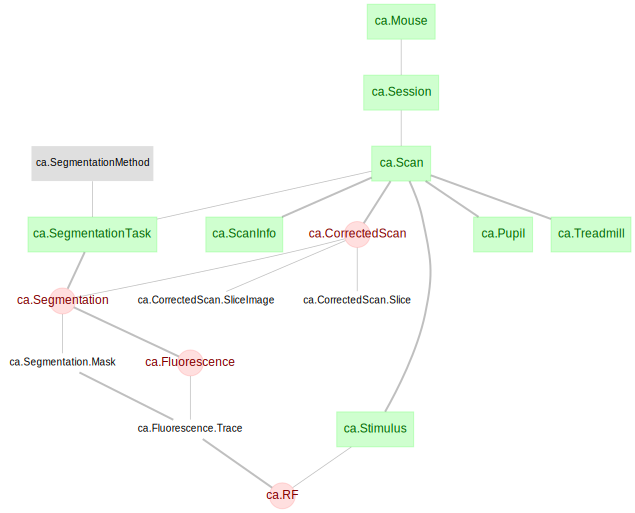

In [3]:
dj.ERD(ca)

In [5]:
schema = dj.schema('eywalker_analysis')

In [6]:
dj.ERD(schema)

In [7]:
combined = ca.Pupil * ca.Treadmill * ca.ScanInfo

In [8]:
combined

mouse_id Unique animal ID,session session number,scan_idx scan ID,pupil_r vector of pupil radii synchronized with slice 1 frame times (pixels),pupil_x vector of pupil x positions synchronized with slice 1 frame times (pixels),pupil_y vector of pupil y positions synchronized with slice 1 frame times (pixels),treadmill_vel velocity of treadmill (may be positive or negative),nframes frames recorded,px_width pixels per line,px_height lines per frame,um_width field of view width (microns),um_height field of view height (microns),bidirectional 1=bidirectional scanning,fps frames per second (Hz),zoom zoom factor (Scanimage-specific),nchannels number of recorded channels,nslices number of slices,fill_fraction raster scan fill fraction (Scanimage-specific),raster_phase shift of odd vs even raster lines
8623,1,5,=BLOB=,=BLOB=,=BLOB=,=BLOB=,27300,256,256,400.0,400.0,1,15.0015,2.1,2,3,0.712867,0.000112568
8804,1,3,=BLOB=,=BLOB=,=BLOB=,=BLOB=,27300,256,256,400.0,400.0,1,14.8313,2.1,2,3,0.712867,1.58586e-05


In [9]:
ca.Treadmill()

mouse_id Unique animal ID,session session number,scan_idx scan ID,treadmill_vel velocity of treadmill (may be positive or negative)
8623,1,5,=BLOB=
8804,1,3,=BLOB=


In [1]:
key = combined.fetch('KEY')[0]
r, v, f =(combined & key).fetch1('pupil_r', 'treadmill_vel', 'fps', squeeze=True)
t = np.r_[:r.size]/f

plt.plot(t, r)
plt.plot(t, abs(v)*10)

plt.legend(('pupil radius', 'running speed'));

NameError: name 'combined' is not defined

In [11]:
@schema
class PupilCorr(dj.Computed):
    definition = """
    -> ca.Pupil
    -> ca.Treadmill 
    -> ca.ScanInfo
    ---
    pupil_corr :  float   # correlation between pupil radius and locomotion velccity
    """
    
    def make(self, key):
        r, v, f =(ca.Pupil * ca.Treadmill * ca.ScanInfo & key).fetch1(
            'pupil_r', 'treadmill_vel', 'fps', squeeze=True)
        t = np.r_[:r.size]/f
        v = abs(v)
        v = v - np.nanmean(v, keepdims=True)
        r = r - np.nanmean(r, keepdims=True)
        r = r / np.sqrt(np.nanmean(r**2))
        v = v / np.sqrt(np.nanmean(v**2))
        c = np.nanmean(r * v)
        self.insert1(dict(key, pupil_corr=c))
        

In [12]:
PupilCorr.key_source

mouse_id Unique animal ID,session session number,scan_idx scan ID
8623,1,5
8804,1,3


In [13]:
PupilCorr.populate(display_progress=True, suppress_errors=False,
                   reserve_jobs=True)

100%|██████████| 2/2 [00:00<00:00, 20.52it/s]


In [14]:
PupilCorr()

mouse_id Unique animal ID,session session number,scan_idx scan ID,pupil_corr correlation between pupil radius and locomotion velccity
8623,1,5,0.438937
8804,1,3,0.495284
